In [94]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
df['Week'] = df['Week'].apply(lambda x: pd.to_datetime(x + '-1', format='%Y-W%U-%w'))
df.set_index('Week', inplace=True)
series = df['Close']
df.head()

,Close
Week,
1971-07-05,890.19
1971-07-12,901.80
1971-07-19,888.51
1971-07-26,887.78
1971-08-02,858.43


In [4]:
# 2. Проверка стационарности с помощью теста Дики-Фуллера
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Series стационарны (p-value <= 0.05)")
    else:
        print("Series нестационарны (p-value > 0.05)")

adf_test(series)

ADF Statistic: -1.3146254984911683
p-value: 0.6224548515589733
Critical Values: {'1%': -3.471633386932248, '5%': -2.8796651107461972, '10%': -2.576433647235832}
Сeries нестационарны (p-value > 0.05)


ADF Statistic: -13.025207881234948
p-value: 2.4075864037417794e-24
Critical Values: {'1%': -3.4718957209472654, '5%': -2.8797795410156253, '10%': -2.5764947265625}
Сeries стационарны (p-value <= 0.05)


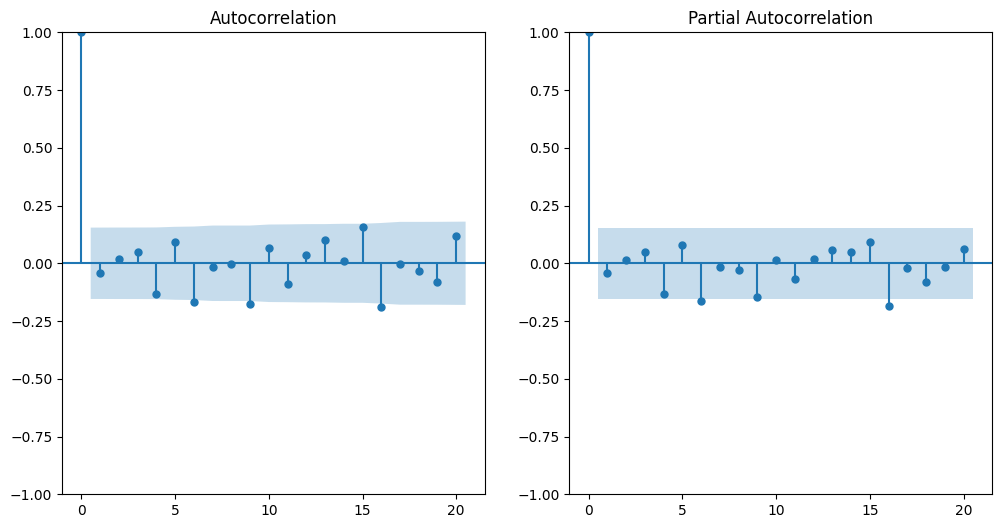

In [5]:
# 3. Дифференцирование для достижения стационарности
diff_series = series.diff().dropna()
adf_test(diff_series)

# 4. Визуализация ACF и PACF для определения параметров p и q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(diff_series, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(diff_series, lags=20, ax=plt.gca())
plt.show()

In [87]:
%%time
# 5. Построение модели ARIMA

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1416.32751 | order: (2, 2, 3)
CPU times: user 1min 36s, sys: 20.4 ms, total: 1min 37s
Wall time: 9.73 s


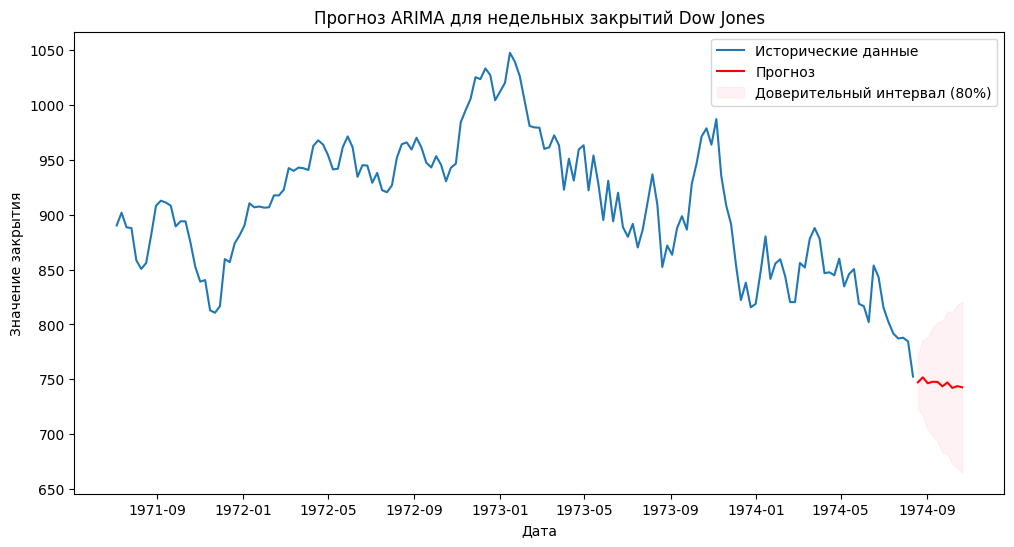

In [122]:
# 7. Прогноз на 10 недель вперед
n_periods = 10
forecast_result = best_mdl.get_forecast(steps=n_periods)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.2)

forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(weeks=1), periods=n_periods, freq='W-MON')
forecast_series = pd.DataFrame({'forecast': forecast}).set_index(forecast_index)
conf_int_df = conf_int.set_index(forecast_index)
conf_int_df.columns = ['lower', 'upper']

# 6. Визуализация прогноза с доверительными интервалами
plt.figure(figsize=(12, 6))
plt.plot(series, label='Исторические данные')
plt.plot(forecast_series, label='Прогноз', color='red')
plt.fill_between(forecast_series.index, 
                 conf_int_df['lower'], 
                 conf_int_df['upper'], 
                 color='pink', alpha=0.2, label='Доверительный интервал (80%)')
plt.title('Прогноз ARIMA для недельных закрытий Dow Jones')
plt.xlabel('Дата')
plt.ylabel('Значение закрытия')
plt.legend()
plt.show()

In [89]:
# автоматический подбор параметров с помощью auto_arima
from pmdarima import auto_arima
auto_model = auto_arima(series, seasonal=False, trace=True, suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1426.500, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1422.147, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1423.867, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1423.877, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1420.447, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1425.858, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.239 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -709.224
Date:                Tue, 10 Jun 2025   AIC                           1420.447
Time:                        11:06:44   BIC                           1423.529
Sample:                             0   HQIC                          1421.699
          

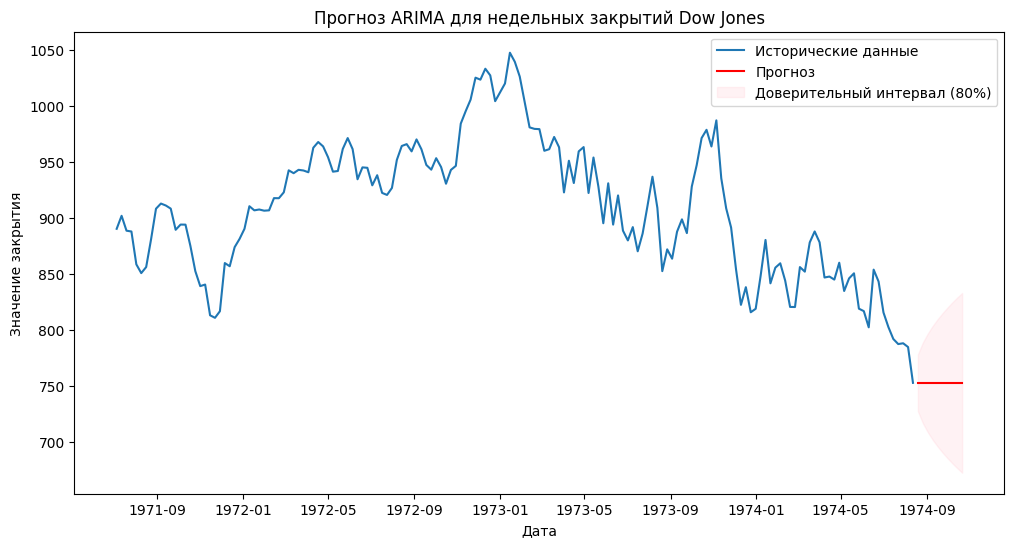

In [106]:
# 5. Прогноз на 10 недель вперед
n_periods = 10
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.2)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(weeks=1), periods=n_periods, freq='W-MON')
forecast_series = pd.DataFrame({'forecast': forecast}).set_index(forecast_index)
conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['lower', 'upper'])

# 6. Визуализация прогноза с доверительными интервалами
plt.figure(figsize=(12, 6))
plt.plot(series, label='Исторические данные')
plt.plot(forecast_series, label='Прогноз', color='red')
plt.fill_between(forecast_series.index, 
                 conf_int_df['lower'], 
                 conf_int_df['upper'], 
                 color='pink', alpha=0.2, label='Доверительный интервал (80%)')
plt.title('Прогноз ARIMA для недельных закрытий Dow Jones')
plt.xlabel('Дата')
plt.ylabel('Значение закрытия')
plt.legend()
plt.show()